# Neuroevolutionary Compiler Optimization Control

## Imports and Setup

In [15]:
import os
from time import time
import pickle
from tqdm import tqdm

import jax
import jax.numpy as jnp
import numpy as np

import evosax
from evosax import LM_MA_ES as ES
from evosax import ParameterReshaper
from evosax.networks import MLP, LSTM

from sklearn.metrics import pairwise_distances

import gym
import compiler_gym

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import ray
ray.init()

## EvoCompiler Environment

In [ ]:
class State:
    def __init__(self, obs, acc_reward, steps):
        self.obs = obs           # observation vector
        self.acc_reward = acc_reward   # accumulated rewards
        self.steps = steps         # Tracks the rollout length.

@ray.remote
def update_action_dist(topk, action_dist, actions):
    actions = np.argpartition(actions, -topk)[:,-topk:]
    for act in actions.flatten():
        action_dist[act] += 1
    return action_dist
        
@ray.remote(num_cpus=1, max_restarts=7)
class SubprocVecEnv:
    def __init__(self, env_name, patience=3):
        import compiler_gym
        self.env = gym.make(env_name)
        self.accumulated_reward = 0
        self.max_reward = 0
        self.init_patience = patience
        self.patience = patience

    def close(self):
        self.env.close()
        
    def reset(self, bench):
        self.patience = self.init_patience
        self.env.reset(benchmark=bench)
        return self.env.observation["InstCountNorm"]
    
    def step(self, actions):
        _, _, done = self.env.step(actions)[:-1]
        obs = self.env.observation["InstCountNorm"]
        r = self.env.reward["IrInstructionCountOz"]
        self.accumulated_reward += r
        if self.accumulated_reward > self.max_reward:
            self.max_reward = self.accumulated_reward
        else:
            self.patience -= 1
            if self.patience < 0:
                done = True
        return obs, r, done
    
    def multistep(self, actions):
        _, _, done = self.env.multistep(actions)[:-1]
        obs = self.env.observation["InstCountNorm"]
        r = self.env.reward["IrInstructionCountOz"]
        self.accumulated_reward += r
        if self.accumulated_reward > self.max_reward:
            self.max_reward = self.accumulated_reward
        else:
            self.patience -= 1
            if self.patience < 0:
                done = True
        return obs, r, done

class EvoCompiler:

    def __init__(self, env_name, dataset_name, pop_size=64, topk=10, num_envs=8, max_steps=100):
        self.env = [SubprocVecEnv.remote(env_name) for _ in range(num_envs)]
        self.pop_size = pop_size
        self.topk = topk
        self.num_envs = num_envs
        self.num_batches = self.pop_size / self.num_envs
        self.max_steps = max_steps
        self.ds = 0
        self.obs_shape, self.act_shape = 0, 0
        with gym.make(env_name) as ENV:
            self.ds = [prog for prog in ENV.datasets[dataset_name].benchmark_uris()]
            if dataset_name == "blas-v0":
                self.ds = self.ds[40:50]
            ENV.reset()
            self.obs_shape, self.act_shape = ENV.observation["InstCountNorm"].shape, \
                                             ENV.action_space.n
        self.ds_size = len(self.ds)
        print("Popsize: {}, Num Envs: {}, Batches: {}, Datasize: {}".format(self.pop_size, self.num_envs, self.num_batches, self.ds_size))

        
    def close(self):
        futures = [env.close.remote() for env in self.env]
    
    def reset(self, prog):
        futures = [env.reset.remote(prog) for env in self.env]
        initial_observations = ray.get(futures)
    
        return State(
            obs=jnp.stack(initial_observations, dtype=jnp.float32),
            acc_reward=jnp.zeros(self.num_envs, dtype=jnp.float32),
            steps=jnp.zeros((), dtype=np.int16),
        )
    
    def step(self, state, actions): # probably will delete lines below as the multistep/fewshot approach works better for mlp
        actions = np.argpartition(actions, -self.topk)[:,-self.topk:]
        futures = [env.multistep.remote(action) for env, action in zip(self.env, actions.tolist())]
        states = ray.get(futures)
        observations, rewards, dones = zip(*states)
        
        return State(
            acc_reward=state.acc_reward + jnp.array(rewards, dtype=jnp.float32),
            obs=jnp.stack(observations, dtype=jnp.float32),
            steps=state.steps+1,
            ), jnp.array(dones, dtype=jnp.float32) 

        
    def rollout(self, forward, PR, population, epoch):
        # split population into batches since the number of envs is constrained
        batches = jnp.split(population, self.num_batches)
        nets = [PR.reshape(batch) for batch in batches]
        
        action_distribution = {}
        
        fitness_vector = jnp.array([])
        for batch in tqdm(nets, desc="Epoch {}".format(epoch), ncols=80):
            batch_fitness = jnp.zeros(self.num_envs)
            for prog in self.ds:
                action_distribution[prog] = {i:0 for i in range(self.act_shape)}
                state = self.reset(prog)
                done, steps = False, 0
                while not done and steps < self.max_steps:
                    obs = state.obs
                    actions = forward(batch, obs)
                    wait = update_action_dist.remote(self.topk, action_distribution[prog], np.array(actions))
                    state, dones = self.step(state, actions)
                    action_distribution[prog] = ray.get(wait)
                    done, step = jnp.alltrue(dones) , state.steps
                batch_fitness = batch_fitness + state.acc_reward
            
            # need to track negatitve reward since evosax minimizes and we want to max
            fitness_vector = jnp.concatenate([fitness_vector, -batch_fitness])
            # could increase efficiency by writing to a preshaped array.
        return fitness_vector/self.ds_size, action_distribution

## Evolution

In [ ]:
env_name = "llvm-v0"
train_name  = "chstone-v0"
test_name = "cbench-v1"
test2_name = "blas-v0"

In [ ]:
pop_size = 40

obs_shape, act_shape = 0, 0

sample_env = EvoCompiler(env_name, train_name, pop_size)
obs_shape, act_shape = sample_env.obs_shape, sample_env.act_shape
del sample_env
    
network = MLP(num_hidden_layers=3, num_output_units=act_shape)
forward = jax.vmap(network.apply, in_axes=0)

rng = jax.random.PRNGKey(42)
rng, init_rng = jax.random.split(rng, 2)
net_params = network.init(rng, jnp.zeros(obs_shape,), init_rng)

# Initialize reshaper based on placeholder network shapes
PR = ParameterReshaper(net_params)

In [ ]:
def fitness_stats(fitness_vector):
    return max(fitness_vector), jnp.mean(fitness_vector), min(fitness_vector)

rng, strategy_rng = jax.random.split(rng, 2)
strategy = ES(popsize=pop_size, num_dims=PR.total_params) 
evo_params = strategy.default_params

evostate = strategy.initialize(strategy_rng, evo_params)

def evolve(rng, evostate, epochs=10, pop_size=64, topk=10, dataset_name=train_name):

    rng, strategy_rng = jax.random.split(rng, 2)

    fitnesses = []
    act_dist = []
    time_vec = []
    
    env = EvoCompiler(env_name, dataset_name, pop_size, topk)
    for e in range(epochs):
        start = time()
        population, evostate = strategy.ask(strategy_rng, evostate, evo_params)
        fitness_vector, action_dist = env.rollout(forward, PR, population, e)
        act_dist.append(action_dist)
        evostate = strategy.tell(population, fitness_vector, evostate, evo_params)
        end = time() - start
        rng, strategy_rng = jax.random.split(rng, 2)
        stats = fitness_stats(-fitness_vector)
        print("Max: {}, Avg: {}, Min: {}".format(*stats))
        fitnesses.append(stats[0])
        time_vec.append(end)
    env.close()
    del env
    
    with open(dataset_name+"_fit_{}_{}.pkl".format(pop_size, topk), "wb") as f:
        pickle.dump(fitnesses, f)
    with open(dataset_name+"_time_{}_{}.pkl".format(pop_size, topk), "wb") as f:
        pickle.dump(time_vec, f)
    with open(dataset_name+"_act_{}_{}.pkl".format(pop_size, topk), "wb") as f:
        pickle.dump(act_dist, f)
    with open(dataset_name+"_state_{}_{}.pkl".format(pop_size, topk), "wb") as f:
        pickle.dump(evostate, f)
        
    print("Finished.")
    return

In [50]:
topk = 20
num_epochs = 15

In [ ]:
evolve(rng, evostate, num_epochs, pop_size, topk, train_name)

In [ ]:
with open("./chstone-v0_state_40_{}.pkl".format(topk), "rb") as f:
    test_state = pickle.load(f)
    evolve(rng, test_state, num_epochs, pop_size, topk, test_name)

In [ ]:
with open("cbench-v1_state_40_{}.pkl".format(topk), "rb") as f:
    test2_state = pickle.load(f)
    evolve(rng, evostate, num_epochs, pop_size, topk, test2_name)

## Visualization

In [16]:

with open("./chstone-v0_fit_40_1.pkl", "rb") as f:
    chstone_k1_fit = pickle.load(f)
    
with open("./chstone-v0_fit_40_5.pkl", "rb") as f:
    chstone_k5_fit = pickle.load(f)
    
with open("./chstone-v0_fit_40_10.pkl", "rb") as f:
    chstone_k10_fit = pickle.load(f)
    
with open("./chstone-v0_fit_40_15.pkl", "rb") as f:
    chstone_k15_fit = pickle.load(f)
    
with open("./cbench-v1_fit_40_1.pkl", "rb") as f:
    cbench_k1_fit = pickle.load(f)
    
with open("./cbench-v1_fit_40_5.pkl", "rb") as f:
    cbench_k5_fit = pickle.load(f)
    
with open("./cbench-v1_fit_40_10.pkl", "rb") as f:
    cbench_k10_fit = pickle.load(f)
    
with open("./cbench-v1_fit_40_15.pkl", "rb") as f:
    cbench_k15_fit = pickle.load(f)
    
with open("./blas-v0_fit_40_1.pkl", "rb") as f:
    blas_k1_fit = pickle.load(f)
    
with open("./blas-v0_fit_40_5.pkl", "rb") as f:
    blas_k5_fit = pickle.load(f)
    
with open("./blas-v0_fit_40_10.pkl", "rb") as f:
    blas_k10_fit = pickle.load(f)

In [46]:
np.max(cbench_k15_fit)

1.0468966

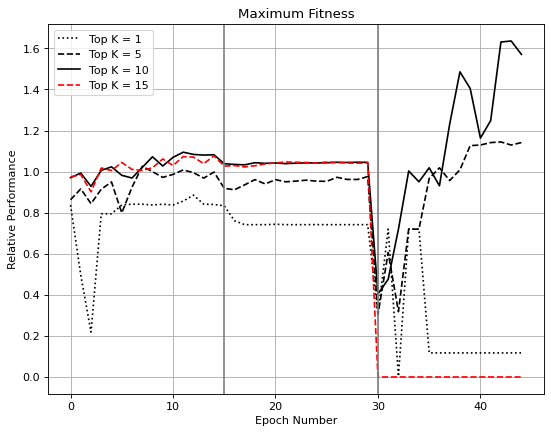

In [20]:
x_vals = [*range(45)]

k1 = np.concatenate([chstone_k1_fit, cbench_k1_fit, blas_k1_fit])
k5 = np.concatenate([chstone_k5_fit, cbench_k5_fit, blas_k5_fit])
k10 = np.concatenate([chstone_k10_fit, cbench_k10_fit, blas_k10_fit])
k15 = np.concatenate([chstone_k15_fit, cbench_k15_fit, np.zeros(15)])


plt.figure(figsize=(8, 6), dpi=80)

# k = 1
plt.plot(x_vals, k1, linestyle="dotted", color="black", label="Top K = 1")

# k = 5
plt.plot(x_vals, k5, linestyle="dashed", color="black", label="Top K = 5")

# k = 10
plt.plot(x_vals, k10, color="black", label="Top K = 10")

# k = 15
plt.plot(x_vals, k15, linestyle="dashed", color="red", label="Top K = 15")

plt.title("Maximum Fitness")
plt.xlabel("Epoch Number")
plt.ylabel("Relative Performance")
plt.axvline(x = 15, color = 'grey')
plt.axvline(x = 30, color = 'grey')
plt.grid()
plt.legend()
plt.show()


In [ ]:
def program_instruction_vectors(dataset_name):
    import compiler_gym
    
    env_vecs = []
    with gym.make("llvm-v0") as ENV:
        ds = [prog for prog in ENV.datasets[dataset_name].benchmark_uris()]
        if dataset_name == "blas-v0":
            ds = ds[40:50]
        
        for prog in ds:
            ENV.reset(prog)
            vec = ENV.observation["InstCountNorm"]
            env_vecs.append(vec)
    labels = [prog.rpartition("/")[-1] for prog in ds]
    return np.array(env_vecs), labels

def intradataset_sim(vecs):
    return 1 - pairwise_distances(vecs, metric="cosine")

def interdataset_sim(vecs_A, vecs_B):
    return 1 - pairwise_distances(vecs_A, vecs_B, metric="cosine")
    

In [ ]:
train_vecs, train_labels = program_instruction_vectors(train_name)
test_vecs, test_labels = program_instruction_vectors(test_name)
test2_vecs, test2_labels = program_instruction_vectors(test2_name)
test2_labels = ["BLAS_{}".format(i) for i in test2_labels]

In [ ]:
train_sim = intradataset_sim(train_vecs)
test_sim = intradataset_sim(test_vecs)
test2_sim = intradataset_sim(test2_vecs)

In [ ]:
train_test_sim = interdataset_sim(train_vecs, test_vecs)
test1_test2_sim = interdataset_sim(test_vecs, test2_vecs)

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(train_sim, cmap="gnuplot")
plt.title("CHStone Program Similarities")
plt.yticks(np.arange(len(train_labels))+.5, train_labels, rotation=0)
plt.xticks(np.arange(len(train_labels))+.5, train_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(test_sim, cmap="gnuplot")
plt.title("cBench Program Similarities")
plt.yticks(np.arange(len(test_labels))+.5, test_labels, rotation=0)
plt.xticks(np.arange(len(test_labels))+.5, test_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(test2_sim, cmap="gnuplot")
plt.title("BLAS Program Similarities")
plt.yticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=0)
plt.xticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(train_test_sim, cmap="gnuplot")
plt.title("CHStone/cBench Program Similarities")
plt.yticks(np.arange(len(train_labels))+.5, train_labels, rotation=0)
plt.xticks(np.arange(len(test_labels))+.5, test_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(test1_test2_sim, cmap="gnuplot")
plt.title("cBench/BLAS Program Similarities")
plt.yticks(np.arange(len(test_labels))+.5, test_labels, rotation=0)
plt.xticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=90)
plt.show()

In [ ]:
chstone_act_dist = None
with open("./chstone-v0_act_40_10.pkl", "rb") as f:
    chstone_act_dist = pickle.load(f)
    
cbench_act_dist = None
with open("./cbench-v1_act_40_10.pkl", "rb") as f:
    cbench_act_dist = pickle.load(f)
    
blas_act_dist = None
with open("./blas-v0_act_40_10.pkl", "rb") as f:
    blas_act_dist = pickle.load(f)

In [ ]:
def plot_action_spectra(act_dist, dataset_name):
    dist_data = []
    for epoch in act_dist:
        epoch_data = np.zeros(124)
        for prog, dist in epoch.items():
            for k, v in dist.items():
                epoch_data[k] += v
        dist_data.append(epoch_data)
    dist_data = np.array(dist_data).T
    
    plt.figure(figsize=(8, 6), dpi=80)
    ax = sns.heatmap(dist_data, cmap="gnuplot")
    plt.title("{} Action Spectra".format(dataset_name))
    plt.show()
    return dist_data

In [ ]:
with open("./action_list.pkl", "rb") as f:
    action_list = pickle.load(f)

In [ ]:
chstone_spectra = plot_action_spectra(chstone_act_dist, "CHStone")

In [ ]:
[action_list[i] for i in np.argpartition(chstone_spectra[:,-1], -5)[-5:]][::-1]

In [ ]:
cbench_spectra = plot_action_spectra(cbench_act_dist, "cBench")

In [ ]:
[action_list[i] for i in np.argpartition(cbench_spectra[:,-1], -5)[-5:]][::-1]

In [ ]:
blas_spectra = plot_action_spectra(blas_act_dist, "BLAS")

In [ ]:
[action_list[i] for i in np.argpartition(blas_spectra[:,-1], -5)[-5:]][::-1]

In [ ]:
def action_distribution_to_vec(act_dist):
    vecs = []
    for prog, dist in act_dist.items():
        prog_vector = np.zeros(124)
        for k, v in dist.items():
            prog_vector[k] += v
        vecs.append(prog_vector)
    vecs = np.array(vecs)
    return vecs

In [ ]:
chstone_act_vecs = action_distribution_to_vec(chstone_act_dist[-1])
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(intradataset_sim(chstone_act_vecs), cmap="gnuplot")
plt.title("CHStone Action Distribution Similarities")
plt.yticks(np.arange(len(train_labels))+.5, train_labels, rotation=0)
plt.xticks(np.arange(len(train_labels))+.5, train_labels, rotation=90)
plt.show()

In [ ]:
cbench_act_vecs = action_distribution_to_vec(cbench_act_dist[-1])
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(intradataset_sim(cbench_act_vecs), cmap="gnuplot")
plt.title("cBench Action Distribution Similarities")
plt.yticks(np.arange(len(test_labels))+.5, test_labels, rotation=0)
plt.xticks(np.arange(len(test_labels))+.5, test_labels, rotation=90)
plt.show()

In [ ]:
blas_act_vecs = action_distribution_to_vec(blas_act_dist[-1])
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(intradataset_sim(blas_act_vecs), cmap="gnuplot")
plt.title("BLAS Action Distribution Similarities")
plt.yticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=0)
plt.xticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(interdataset_sim(chstone_act_vecs,cbench_act_vecs), cmap="gnuplot")
plt.title("CHStone/cBench Action Distribution Similarities")
plt.yticks(np.arange(len(train_labels))+.5, train_labels, rotation=0)
plt.xticks(np.arange(len(test_labels))+.5, test_labels, rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(interdataset_sim(cbench_act_vecs, blas_act_vecs), cmap="gnuplot")
plt.title("cBench/BLAS Action Distribution Similarities")
plt.yticks(np.arange(len(test_labels))+.5, test_labels, rotation=0)
plt.xticks(np.arange(len(test2_labels))+.5, test2_labels, rotation=90)
plt.show()

In [35]:
with open("chstone-v0_time_40_1.pkl", "rb") as f:
    chstone_time_k1 = np.sum(pickle.load(f))

with open("chstone-v0_time_40_5.pkl", "rb") as f:
    chstone_time_k5 = np.sum(pickle.load(f))
    
with open("chstone-v0_time_40_10.pkl", "rb") as f:
    chstone_time_k10 = np.sum(pickle.load(f))
    
with open("chstone-v0_time_40_15.pkl", "rb") as f:
    chstone_time_k15 = np.sum(pickle.load(f))    

with open("cbench-v1_time_40_1.pkl", "rb") as f:
    cbench_time_k1 = np.sum(pickle.load(f))
    
with open("cbench-v1_time_40_5.pkl", "rb") as f:
    cbench_time_k5 = np.sum(pickle.load(f))
    
with open("cbench-v1_time_40_10.pkl", "rb") as f:
    cbench_time_k10 = np.sum(pickle.load(f))

with open("cbench-v1_time_40_15.pkl", "rb") as f:
    cbench_time_k15 = np.sum(pickle.load(f))
    
with open("blas-v0_time_40_1.pkl", "rb") as f:
    blas_time_k1 = np.sum(pickle.load(f))
    
with open("blas-v0_time_40_5.pkl", "rb") as f:
    blas_time_k5 = np.sum(pickle.load(f))
    
with open("blas-v0_time_40_10.pkl", "rb") as f:
    blas_time_k10 = np.sum(pickle.load(f))

In [66]:
time_data = [
    [chstone_time_k1,cbench_time_k1,blas_time_k1],
    [chstone_time_k5,cbench_time_k5,blas_time_k5],
    [chstone_time_k10,cbench_time_k10,blas_time_k10],
    [chstone_time_k15,cbench_time_k15,0.0]
]

In [67]:
time_data = np.array(time_data)

In [68]:
time_data[:,0] /= 12
time_data[:,1] /= 23
time_data[:,2] /= 10
time_data

array([[ 14.94243524,  29.34921723,  11.96994412],
       [ 19.94964776, 115.71422768,  12.77255132],
       [ 21.97504409, 159.08564233,  15.08244255],
       [ 33.98937056, 257.04475453,   0.        ]])

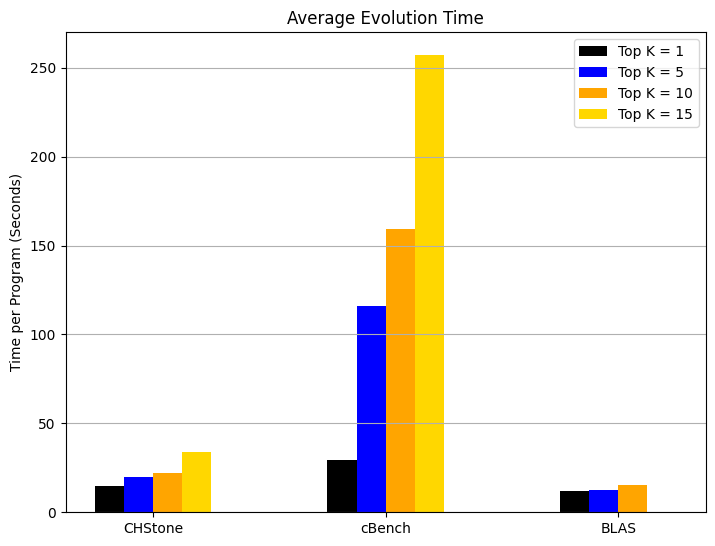

In [72]:
ind = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind - 0.1875, time_data[0], color = 'k', width = 0.125, label="Top K = 1")
ax.bar(ind - 0.0625, time_data[1], color = 'b', width = 0.125, label="Top K = 5")
ax.bar(ind + 0.0625, time_data[2], color = 'orange', width = 0.125, label="Top K = 10")
ax.bar(ind + 0.1875, time_data[3], color = 'gold', width = 0.125, label="Top K = 15")
ax.set_xticks(ind, ('CHStone', 'cBench', 'BLAS'))
plt.legend()
plt.grid(axis="y")
plt.ylabel("Time per Program (Seconds)")
plt.title("Average Evolution Time")
plt.show()